# Chapter7 二次元画像解析

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [2]:
img = io.imread("../chapter06/stable-diffusion_柴田真宏_anime.png")

## 3.1
> 画像が明るすぎて白飛びが発生している箇所と黒く潰れている箇所は, それぞれR, G, Bの明度値が(255, 255, 255), (0, 0, 0)になっている. このような画素の色を(255, 0, 0)に書き換えて保存することで, 白飛びと黒潰れの領域を可視化するコードを作成せよ.

In [3]:
def visualize_blank(image):
    out_image = image.copy()
    out_image = np.where(
        ((out_image == np.array([0, 0, 0]))|(out_image == np.array([255, 255, 255]))).all(axis = 2, keepdims= True),
        np.array([255, 0, 0]),
        out_image)
    return out_image.astype(np.uint8)

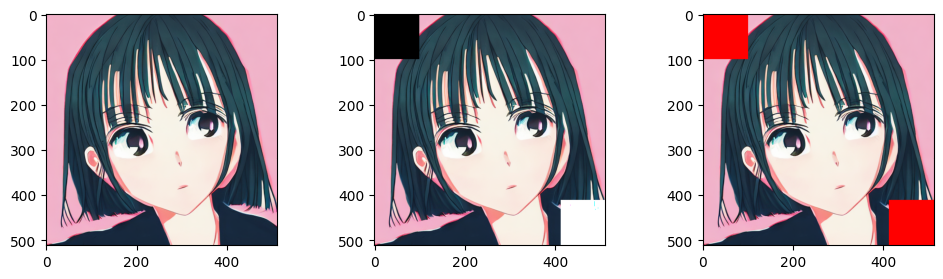

In [4]:
h, w, ch = img.shape
l = 100
m = h - 2*l
n = w - 2*l
img_blank = img * np.vstack((
    np.hstack((np.zeros((l, l, ch)), np.ones((l, n, ch)), np.ones((l, l, ch)))),
    np.hstack((np.ones((m, l, ch)), np.ones((m, n, ch)), np.ones((m, l, ch)))),
    np.hstack((np.ones((l, l, ch)), np.ones((l, n, ch)), np.ones((l, l, ch))*255))
    ))
img_blank = np.clip(img_blank, 0, 255).astype(np.uint8)
img_red = visualize_blank(img_blank)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].imshow(img)
ax[1].imshow(img_blank)
ax[2].imshow(img_red)
plt.show()

## 3.2
> 画像のR, G, Bそれぞれの平均値と分散を算出し表示するコードを作成せよ.

In [5]:
def rgb_moment(image):
    for i, c in enumerate(["R", "G", "B"]):
        print(f"{c}: mean {np.mean(image[..., i]):.2f}, var {np.var(image[..., i]):.2f}")

def hist_brightness(image):
    _, _, ch = image.shape
    fig, ax = plt.subplots(ch, 1)
    for i in range(ch):
        ax[i].hist(image[..., i].flatten(), bins = 255)
    plt.show()

R: mean 139.45, var 10811.26
G: mean 129.90, var 5820.48
B: mean 140.09, var 4967.96


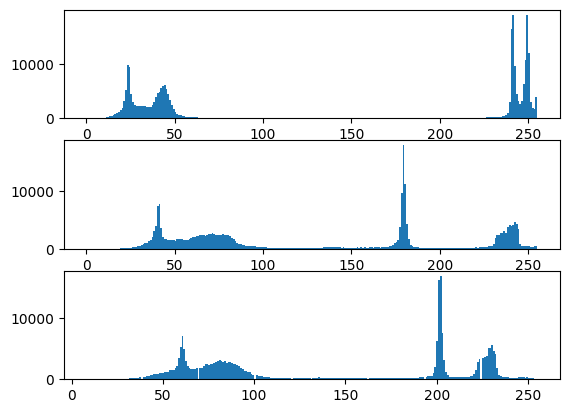

In [6]:
rgb_moment(img)
hist_brightness(img)

## 3.3
> 求まった平均値と分散を使って, 明度変換のパラメータ`a, b`を自動で決定する方法を考えよ.
## 3.4
> プログラムリスト3.1を変更し, 練習問題3.3で考えた方法で自動的に明度調整を行うコードを作成せよ.
```{python}
# program list 3.1
height, width, channel = dat.shape
a=1.5
b=-10
for y in range(height):
    for x in range(width):
        for ch in range(channel):
            k=(int(dat[y][x][ch])-128)*a+128+b
            if (k>255):
                k=255
            elif (k<0):
                k=0
            dat[y][x][ch]=k
```

In [7]:
def adjust_brightness(image, a = 64, b = 128):
    out_image = image.copy()
    _, _, channel = out_image.shape
    for i in range(channel):
        mean = np.mean(out_image[..., i])
        sd = np.std(out_image[..., i])
        k = (out_image[..., i] - mean) / sd * a + b
        out_image[..., i] = np.clip(k, 0, 255)

    return out_image.astype(np.uint8) 


R: mean 127.51, var 4096.54
G: mean 127.54, var 4100.46
B: mean 127.56, var 4098.47


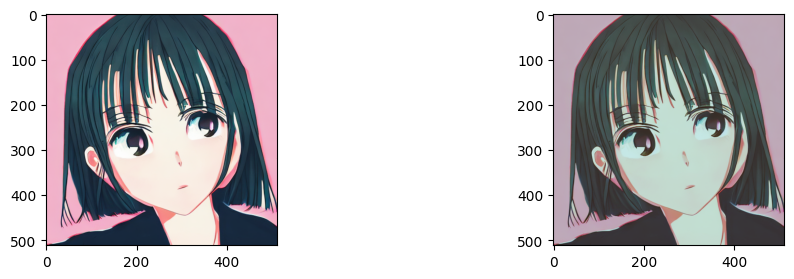

In [8]:
img_adjust = adjust_brightness(img)
rgb_moment(img_adjust)

fig, ax = plt.subplots(1, 2, figsize = (12, 3))
ax[0].imshow(img)
ax[1].imshow(img_adjust)
plt.show()

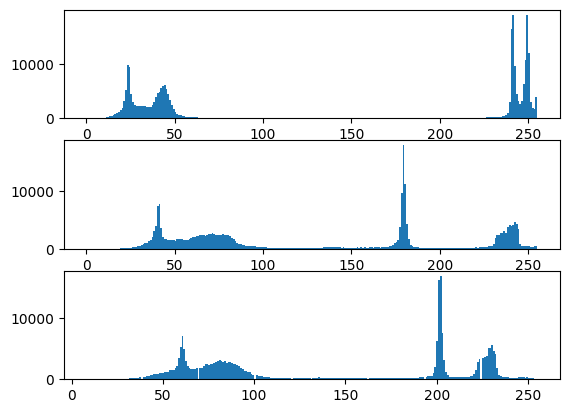

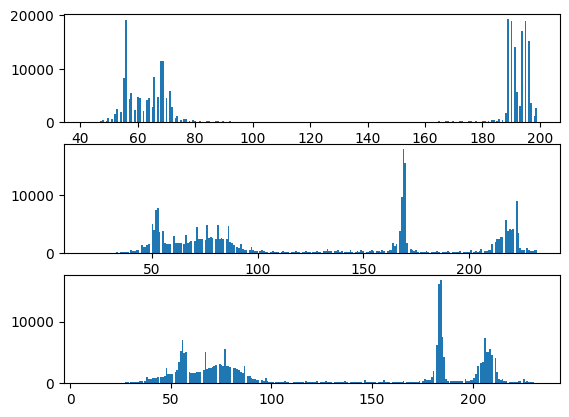

In [9]:
hist_brightness(img)
hist_brightness(img_adjust)

## 3.5
> 1次微分フィルタを使ったフィルタ処理を実装し, 自身で準備した画像に対してエッジ検出を行え.

In [10]:
def filtering(image, filter):
    image = image.copy().astype(np.float32)
    
    # padding
    h, w = filter.shape
    pad_h = h // 2
    pad_w = w // 2
    
    image = np.pad(image, [(pad_h, pad_h), (pad_w, pad_w), (0, 0)], "edge")
    out_image = np.zeros_like(image)
    
    height, width = out_image.shape[:2]
    channel = 1 if len(out_image.shape) == 2 else out_image.shape[2]
    
    # filtering
    for y in range(pad_h, height-pad_h):
        for x in range(pad_w, width-pad_w):
            for ch in range(channel):
                out_image[y, x, ch] = (image[y-pad_h : y+pad_h+1, x-pad_w : x+pad_w+1, ch]*filter).sum()
            
    out_image = out_image[pad_h : height-pad_h, pad_w : width-pad_w]
    return np.clip(out_image, 0, 255).astype(np.uint8)

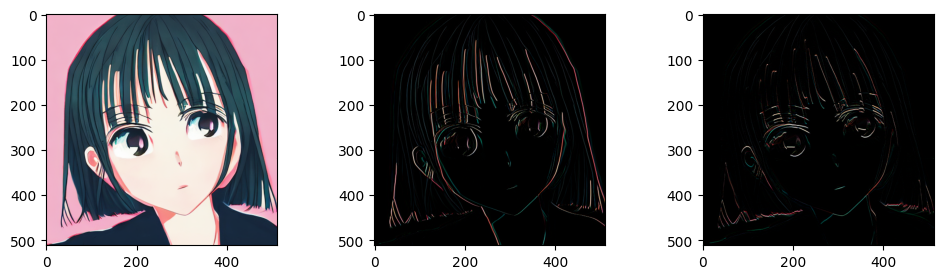

In [11]:
oned_filter_w = np.array([[0.0, 0.0, 0.0], [-1.0, 0.0, 1.0], [0.0, 0.0, 0.0]])
oned_filter_h = oned_filter_w.T

img_edge_w = filtering(img, oned_filter_w)
img_edge_h = filtering(img, oned_filter_h)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].imshow(img)
ax[1].imshow(img_edge_w)
ax[2].imshow(img_edge_h)
plt.show()

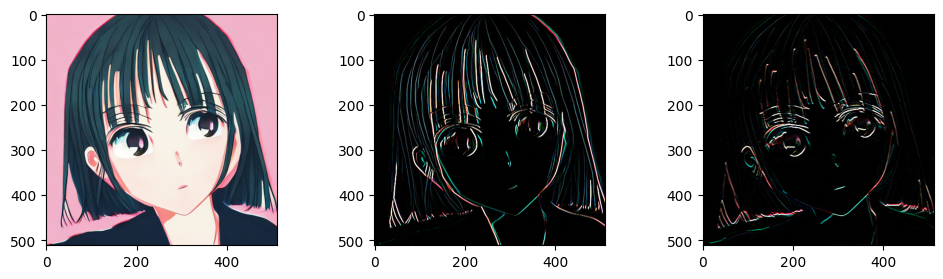

In [12]:
prewitt_w = np.array([[-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0], [-1.0, 0.0, 1.0]])
prewitt_h = prewitt_w.T

img_edge_w = filtering(img, prewitt_w)
img_edge_h = filtering(img, prewitt_h)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].imshow(img)
ax[1].imshow(img_edge_w)
ax[2].imshow(img_edge_h)
plt.show()

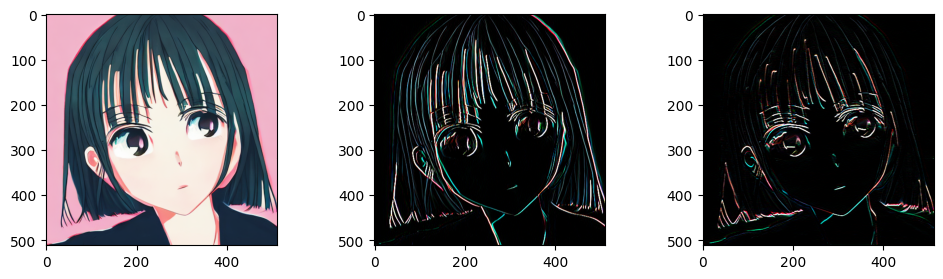

In [13]:
sobel_w = np.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
sobel_h = sobel_w.T

img_edge_w = filtering(img, sobel_w)
img_edge_h = filtering(img, sobel_h)

fig, ax = plt.subplots(1, 3, figsize = (12, 3))
ax[0].imshow(img)
ax[1].imshow(img_edge_w)
ax[2].imshow(img_edge_h)
plt.show()

## 3.6
> OpenCVの説明書や解説サイトを参考に, OpenCVライブラリを使ってFAST特徴点を検出してみよ.

[docs of OpenCV](https://docs.opencv.org/4.6.0/df/d0c/tutorial_py_fast.html)

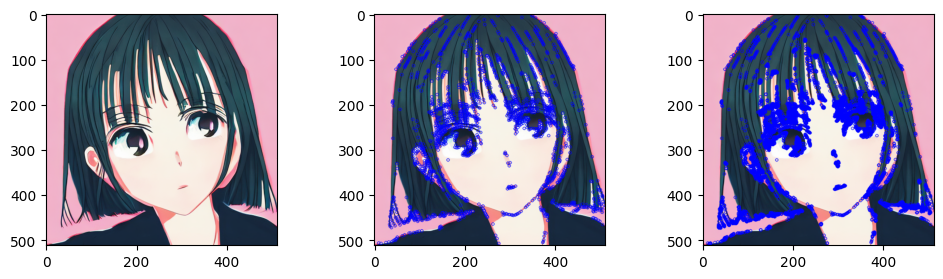

In [14]:
fast = cv2.FastFeatureDetector_create()
kp = fast.detect(img, None)
img2 = cv2.drawKeypoints(img, kp, None, color=(0,0,255))

fast.setNonmaxSuppression(0)
kp = fast.detect(img, None)
img3 = cv2.drawKeypoints(img, kp, None, color=(0,0,255))

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
ax[0].imshow(img)
ax[1].imshow(img2)
ax[2].imshow(img3)
plt.show()

## 3.7
> 同じ解像度の2枚の画像を入力し, SSDを計算することで2枚の画像の類似度を算出せよ.

In [15]:
def ssd(image1, image2):
    if image1.shape != image2.shape:
        raise AssertionError("shapes of images must be the same!!")

    return np.sum((image1 - image2)**2)

In [16]:
img2 = io.imread("../chapter06/stable-diffusion_柴田真宏_anime_2.png")
ssd(img, img_red), ssd(img, img2)

(7606132, 78712333)